# Spin file of Phobos for Marco's TPM

2025-09-03

- Motivation
    - A spin file is necessary to perform TPM of Phobos. However, a rotation phase (`phi0`) of Phobos at an input epoch (J2000) is unknown. 
- Method
    - We calculate sub-observer point (longitude, `solon` and latitude, `solat`) and sub-solar point (longitude, `sslon` and latitude, `sslat`) by running TPMs (`runtpm`) by changing `phi0` with a step of 0.1 deg (i.e., -180, -179.9, ..., 179.8, and 179.9 deg). 
    - The shape model from `Ernst+2023` is used in the TPMs. We calclated (`sslon`, `sslat`) at `2004-08-22` and `2009-08-22`.
    - The goal is to find the `phi0` that gives (`sslon`, `sslat`) matching the (`sslon`, `sslat`) obtained from SPICE Kernel by Joel.
- Results
    -  The `phi0` are determined to be -97.08 (to match sub-observer points) and -97.06 (to match sub-solar points) for epoch1 (`2004-08-22`), while `phi0` are determined to be -96.94 (to match sub-observer points) and -97.35 (to match sub-solar points) for epoch2 (`2009-08-22`).

- TODO
    - Check options about light-time correction and abbreviation https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html

- MEMO
    - Shape model does not matter. Sub-observer and sub-solar points are almost identical. (2025-09-01)
    - TPMs with (`solon`, `solat`) = (4.817162 deg,  355.182838 deg = 360 - 4.817162 deg) return the same flux, sub-observer points, and sub-solar points.
    - TPMs with `phi0` of 180 and `phi0` of -180 return the same flux, sub-observer points, and sub-solar points.

- Next step
    - Joel will modify the code to get spin file from SPICE Kernel using the `phi0`.
    - Jin will perform TPMs of Phobos with VLT/VISIR N-band spectroscopy. The data was obtained on August 15, 2018.

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import subprocess, os

In [170]:
# These are provided by Joel.
# Obtained with SPICE Kernel.

## Spin (longitude, latitude, rotation period) 
lam_deg, beta_deg, P_hr = -4.817162, 63.662074, 7.653843686551412

# Epoch T0 -> It doesn't matter.
# 2000-01-01T12:00:00
JD0 = 2451545

## Vectors 
# Epoch 1
# Asteroid to Observer in km
# as of 2025-09-01
X0, Y0, Z0 = -11966.41210964, 1880.57461077, -6920.96168241
X1, Y1, Z1 = -80.48137113,  -77.93638837, -126.1307605
# as of 2025-09-02
X0, Y0, Z0 = -11966.48477263, 1880.53059752, -6921.05617657
X1, Y1, Z1 = -80.48392846,  -77.93915375, -126.13722909
# Asteroid to Sun in km
# as of 2025-09-01
x0, y0, z0 = -2.46456188e+08,  3.48122425e+07,  1.04415276e+07
x1, y1, z1 = -2.46731352e+08,  3.26568853e+07,  1.02650841e+07
# as of 2025-09-02
x0, y0, z0 = -2.36810937e+08,  7.69822212e+07, 7.43409985e+06
x1, y1, z1 = -2.37366744e+08,  7.51629583e+07,  7.40704272e+06

vec_o_0_epoch1 = (X0, Y0, Z0)
vec_o_1_epoch1 = (X1, Y1, Z1)
vec_s_0_epoch1 = (x0, y0, z0)
vec_s_1_epoch1 = (x1, y1, z1)


# Epoch2
# Asteroid to Observer in km
# as of 2025-09-01
X0, Y0, Z0 = -1522.61218629, -9343.63603304, 869.53603853
X1, Y1, Z1 = -1153.59568396, 8104.68197555, 8040.42339567
# as of 2025-09-02
X0, Y0, Z0 = -1153.58888442, 8105.03077788, 8040.88333807
X1, Y1, Z1 = -1522.63355418, -9343.24831881, 869.49912146

# Asteroid to Sun in km
# as of 2025-09-01
x0, y0, z0 = 1.13260674e+08, 1.88587012e+08, 1.48474049e+07
x1, y1, z1 = 1.14919690e+08, 1.87377719e+08, 1.47235213e+07
# as of 2025-09-02
x0, y0, z0 = 1.41230837e+08, 1.69078975e+08, 7.66535590e+04
x1, y1, z1 = 1.39693065e+08, 1.70585368e+08, 1.47987226e+05

vec_o_0_epoch2 = (X0, Y0, Z0)
vec_o_1_epoch2 = (X1, Y1, Z1)
vec_s_0_epoch2 = (x0, y0, z0)
vec_s_1_epoch2 = (x1, y1, z1)


# Epoch 1
# Sub-Spacecraft Longitude:  3.6889139491168237 Sub-Spacecraft Latitude:  59.74251833730538
solon_epoch1, solat_epoch1 = 3.6889139491168237, 59.74251833730538
sslon_epoch1, sslat_epoch1 = -93.51012870211578, 23.95300523703233

# Epoch 2
solon_epoch2, solat_epoch2 = 93.82473600494285, -3.0294349689766773            
sslon_epoch2, sslat_epoch2 = -111.07815470804785, -14.876620634494028


In [171]:
# Make spin file (common for Epoch 1 and Epoch 2)
# See ./test
spinfile_list = []
dir = "../test/spinfiles"

phi0_tpm = np.arange(-180, 180, 0.1)
#phi0_tpm = [x for x in phi0_tpm]
for phi0 in phi0_tpm:    
    # Filename
    sf = f"spin_Phobos_phi0_{np.round(phi0, 1)}.txt"
    sf = os.path.join(dir, sf)
    # Save filename
    spinfile_list.append(sf)

    # Make spin file
    with open(sf, "w") as f:
        # lam, beta, P      
        f.write(f"{lam_deg} {beta_deg} {P_hr}\n")
        # JD0
        f.write(f"{JD0} {phi0}\n")
        # Scattering parameters
        # This doesn't matter (these are values for Eros)
        f.write(f"0.43 -0.29 0.22 1 36")
 
print("These spin files will be used here")
print(spinfile_list)

These spin files will be used here
['../test/spinfiles/spin_Phobos_phi0_-180.0.txt', '../test/spinfiles/spin_Phobos_phi0_-179.9.txt', '../test/spinfiles/spin_Phobos_phi0_-179.8.txt', '../test/spinfiles/spin_Phobos_phi0_-179.7.txt', '../test/spinfiles/spin_Phobos_phi0_-179.6.txt', '../test/spinfiles/spin_Phobos_phi0_-179.5.txt', '../test/spinfiles/spin_Phobos_phi0_-179.4.txt', '../test/spinfiles/spin_Phobos_phi0_-179.3.txt', '../test/spinfiles/spin_Phobos_phi0_-179.2.txt', '../test/spinfiles/spin_Phobos_phi0_-179.1.txt', '../test/spinfiles/spin_Phobos_phi0_-179.0.txt', '../test/spinfiles/spin_Phobos_phi0_-178.9.txt', '../test/spinfiles/spin_Phobos_phi0_-178.8.txt', '../test/spinfiles/spin_Phobos_phi0_-178.7.txt', '../test/spinfiles/spin_Phobos_phi0_-178.6.txt', '../test/spinfiles/spin_Phobos_phi0_-178.5.txt', '../test/spinfiles/spin_Phobos_phi0_-178.4.txt', '../test/spinfiles/spin_Phobos_phi0_-178.3.txt', '../test/spinfiles/spin_Phobos_phi0_-178.2.txt', '../test/spinfiles/spin_Phobos_ph

In [172]:
## Parameters for TPM (not important in this test)

# emissivity
eps = 0.9
BondA = 0.10
TI = 0
# Assume no craters (ca = 0, cr = 0)
ca, cr = 0, 0

# Shape model (The lowest resolution one in Ernst+2023. Downloaded from https://sbmt.jhuapl.edu/Object-Template.php?obj=44 -> all_phobos_shapes_v002.zip)
# Renamed by JB
f_obj = "../test/Phobos_lowres.obj"

# OLD but traditional one provided by Joel on 2025-09-01 "Phobos Shape File"
# It's natural to use the shape model
#obj = "../test/PHOBOS_M003_GAS_V01.OBJ"


In [173]:

def make_eph_obs_Phobos(f_eph, f_obs, utc0, utc1, vec_observer_0, vec_observer_1, vec_sun_0, vec_sun_1):
    """Make ephemeris and observation files of Phobos.

    Parameters
    ----------
    f_eph : str
        output ephemeris file
    f_obs : str
        output observation file
    utc0, utc1 : str
        time 0 and 1 
    vec_observer_0, vec_observer_1 : array-like
        Phobos-observer vectors at utc0 and utc1 
    vec_sun_0, vec_sun_1 : array-like
        Phobos-Sun vectors at utc0 and utc1 
    """

    X0, Y0, Z0 = vec_observer_0
    X1, Y1, Z1 = vec_observer_1
    x0, y0, z0 = vec_sun_0
    x1, y1, z1 = vec_sun_1

    # km/au 
    km_over_AU = 149_597_870.7

    # Convert utc to JD
    jd0 = Time(utc0, format="isot", scale="utc").jd
    jd1 = Time(utc1, format="isot", scale="utc").jd

    # From km to AU
    X0 /= km_over_AU
    Y0 /= km_over_AU
    Z0 /= km_over_AU
    X1 /= km_over_AU
    Y1 /= km_over_AU
    Z1 /= km_over_AU

    x0 /= km_over_AU
    y0 /= km_over_AU
    z0 /= km_over_AU
    x1 /= km_over_AU
    y1 /= km_over_AU
    z1 /= km_over_AU

    # Better to be done in SPICE Kernel?
    X0 = -X0
    Y0 = -Y0
    Z0 = -Z0

    X1 = -X1
    Y1 = -Y1
    Z1 = -Z1

    x0 = -x0
    y0 = -y0
    z0 = -z0
    x1 = -x1
    y1 = -y1
    z1 = -z1

    print("Phobos -> Observer")
    print(f" (X0, Y0, Z0) = ({X0:.10f}, {Y0:.10f}, {Z0:.10f})")
    print(f" (X1, Y1, Z1) = ({X1:.10f}, {Y1:.10f}, {Z1:.10f})")
    print("Phobos -> Sun")
    print(f" (x0, y0, z0) = ({x0:.10f}, {y0:.10f}, {z0:.10f})")
    print(f" (x1, y1, z1) = ({x1:.10f}, {y1:.10f}, {z1:.10f})")

    # Ephemeris file
    # T [JD], x [au], y [au], z [au] (Vector from asteroid to the Sun)
    with open(f_eph, "w") as f:
        # Warming up is important
        f.write(f"{jd0-10} {x0} {y0} {z0}\n")
        f.write(f"{jd0} {x0} {y0} {z0}\n")
        f.write(f"{jd1} {x1} {y1} {z1}\n")
        # Dummy, which is necessary
        f.write(f"{jd1+1} {x1} {y1} {z1}")

    # Observation file
    # Observations are all dummy!
    N_data = 1
    N_data_obs = 1
    w1, f1, ferr1 = 9.0, 10, 1 
    with open(f_obs, "w") as f:
        f.write(f"{N_data}\n")
        f.write("\n")
        f.write(f"{jd1} {N_data_obs}\n")
        f.write(f"{x1} {y1} {z1}\n")
        f.write(f"{X1} {Y1} {Z1}\n")
        f.write(f"{w1} {f1} {ferr1}\n")


def runtpm_Phobos(f_obj, f_eph, f_obs, spinfile_list, eps, TI, BondA, ca, cr):

    sslon_tpm, sslat_tpm = [], []
    solon_tpm, solat_tpm = [], []
    for f_spin in spinfile_list:

        cmd = f'echo {f_obj} {f_eph} {eps} {TI} {BondA} {ca} {cr} | runtpm -o {f_obs} -S {f_spin} | grep "so>"'
        print(f"Command: {cmd}")
        p = subprocess.Popen(cmd, shell=True, preexec_fn=os.setsid, stdout=subprocess.PIPE, stdin=subprocess.PIPE)
        comm = p.communicate()
        output = comm[0].decode('ascii').strip()
        print(output)
        print(output.split(" "))

        out_sp = output.split(" ")
        # Sometimes with nothing ""
        out_sp = [x for x in out_sp if x!= ""]

        assert len(out_sp) == 6, "Check the code"
        # Extract so longitude and latitude from "ss> 2453240.0044566263  93.04 -26.76	so> 233.02 -84.39"

        sslon, sslat = out_sp[2], out_sp[3].split("\t")[0]
        solon, solat = out_sp[4], out_sp[5]

        sslon_tpm.append(float(sslon))
        sslat_tpm.append(float(sslat))
        solon_tpm.append(float(solon))
        solat_tpm.append(float(solat))
    return solon_tpm, solat_tpm, sslon_tpm, sslat_tpm

    

In [174]:
def find_intersections(phi, y_tpm, y_spice):
    """Find intersetions by linear interpolation"""
    intersections = []
    diff = np.array(y_tpm) - y_spice  # diff
    for i in range(len(diff)-1):
        if diff[i] * diff[i+1] < 0:  # sign 
            # Linear interpolation
            phi_int = phi[i] - diff[i] * (phi[i+1] - phi[i]) / (diff[i+1] - diff[i])
            intersections.append(phi_int)
    return intersections

def plot_subobserver_subsolar(phi0_tpm, solon, solat, sslon, sslat,
                              solon_SPICE, solat_SPICE, sslon_SPICE, sslat_SPICE):

    fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True)

    titles = [
        "Sub-observer longitude [deg]",
        "Sub-observer latitude [deg]",
        "Sub-solar longitude [deg]",
        "Sub-solar latitude [deg]"
    ]
    
    ylims = [(-180, 180), (-90, 90), (-180, 180), (-90, 90)]
    spice_values = [solon_SPICE, solat_SPICE, sslon_SPICE, sslat_SPICE]
    tpm_values = [
        [float(x - 180) for x in solon],  # 0–360 → -180–180
        solat,
        [float(x - 180) for x in sslon],
        sslat
    ]

    # List for intersection
    intersection_colors = ["blue", "green", "purple", "orange", "cyan"]

    for idx, (ax, title, ylim, spice, tpm) in enumerate(zip(axes, titles, ylims, spice_values, tpm_values)):
        ax.set_xlabel("$\phi$ [deg]")
        ax.set_ylabel(title)
        ax.set_ylim(ylim)
        ax.set_xlim([-180, 180])
        ax.hlines(spice, -180, 180, color="black", ls="solid", label="SPICE Kernel", zorder=100)
        ax.scatter(phi0_tpm, tpm, color="red", label="TPM", zorder=50)

        # Calculate intersection
        if "longitude" in title.lower():
            intersections = find_intersections(phi0_tpm, tpm, spice)
            for i, x in enumerate(intersections):
                color = intersection_colors[i % len(intersection_colors)]
                ax.axvline(x, color=color, ls="--", 
                           label=f"Intersection φ={x:.2f}°")
            if intersections:
                print(f"{title} intersections at: {intersections}")

        ax.legend()

    plt.tight_layout()
    plt.show()


## Epoch 1: 2004-08-22
- `phi0` ~ -97.08 (to match sub-observer points), -97.06 (to match sub-solar point)

In [161]:
# Make ephemeris and observation file
f_eph = "../test/eph_Phobos_epoch1.txt"
f_obs = "../test/obs_Phobos_epoch1.txt"
utc0 = "2004-08-21T12:06:25.0525"
utc1 = "2004-08-22T12:06:25.0525"

make_eph_obs_Phobos(f_eph, f_obs, utc0, utc1, vec_o_0_epoch1, vec_o_1_epoch1, vec_s_0_epoch1, vec_s_1_epoch1)

Phobos -> Observer
 (X0, Y0, Z0) = (0.0000799910, -0.0000125706, 0.0000462644)
 (X1, Y1, Z1) = (0.0000005380, 0.0000005210, 0.0000008432)
Phobos -> Sun
 (x0, y0, z0) = (1.5829833399, -0.5145943645, -0.0496938881)
 (x1, y1, z1) = (1.5866986802, -0.5024333431, -0.0495130224)


In [162]:
# Run TPM for all phi0 and save sub-observer and sub-solar points
solon1, solat1, sslon1, sslat1 = runtpm_Phobos(f_obj, f_eph, f_obs, spinfile_list, eps, TI, BondA, ca, cr)


Command: echo ../test/Phobos_lowres.obj ../test/eph_Phobos_epoch1.txt 0.9 0 0.1 0 0 | runtpm -o ../test/obs_Phobos_epoch1.txt -S ../test/spinfiles/spin_Phobos_phi0_-180.0.txt | grep "so>"
ss> 2453240.0044566263 169.43  23.95	so> 266.61  59.74
['ss>', '2453240.0044566263', '169.43', '', '23.95\tso>', '266.61', '', '59.74']
Command: echo ../test/Phobos_lowres.obj ../test/eph_Phobos_epoch1.txt 0.9 0 0.1 0 0 | runtpm -o ../test/obs_Phobos_epoch1.txt -S ../test/spinfiles/spin_Phobos_phi0_-179.9.txt | grep "so>"
ss> 2453240.0044566263 169.33  23.95	so> 266.51  59.74
['ss>', '2453240.0044566263', '169.33', '', '23.95\tso>', '266.51', '', '59.74']
Command: echo ../test/Phobos_lowres.obj ../test/eph_Phobos_epoch1.txt 0.9 0 0.1 0 0 | runtpm -o ../test/obs_Phobos_epoch1.txt -S ../test/spinfiles/spin_Phobos_phi0_-179.8.txt | grep "so>"
ss> 2453240.0044566263 169.23  23.95	so> 266.41  59.74
['ss>', '2453240.0044566263', '169.23', '', '23.95\tso>', '266.41', '', '59.74']
Command: echo ../test/Phobos

Sub-observer longitude [deg] intersections at: [-97.07891394912153, 86.65103609721993]
Sub-solar longitude [deg] intersections at: [-97.05987129788893, -10.575976695953536]


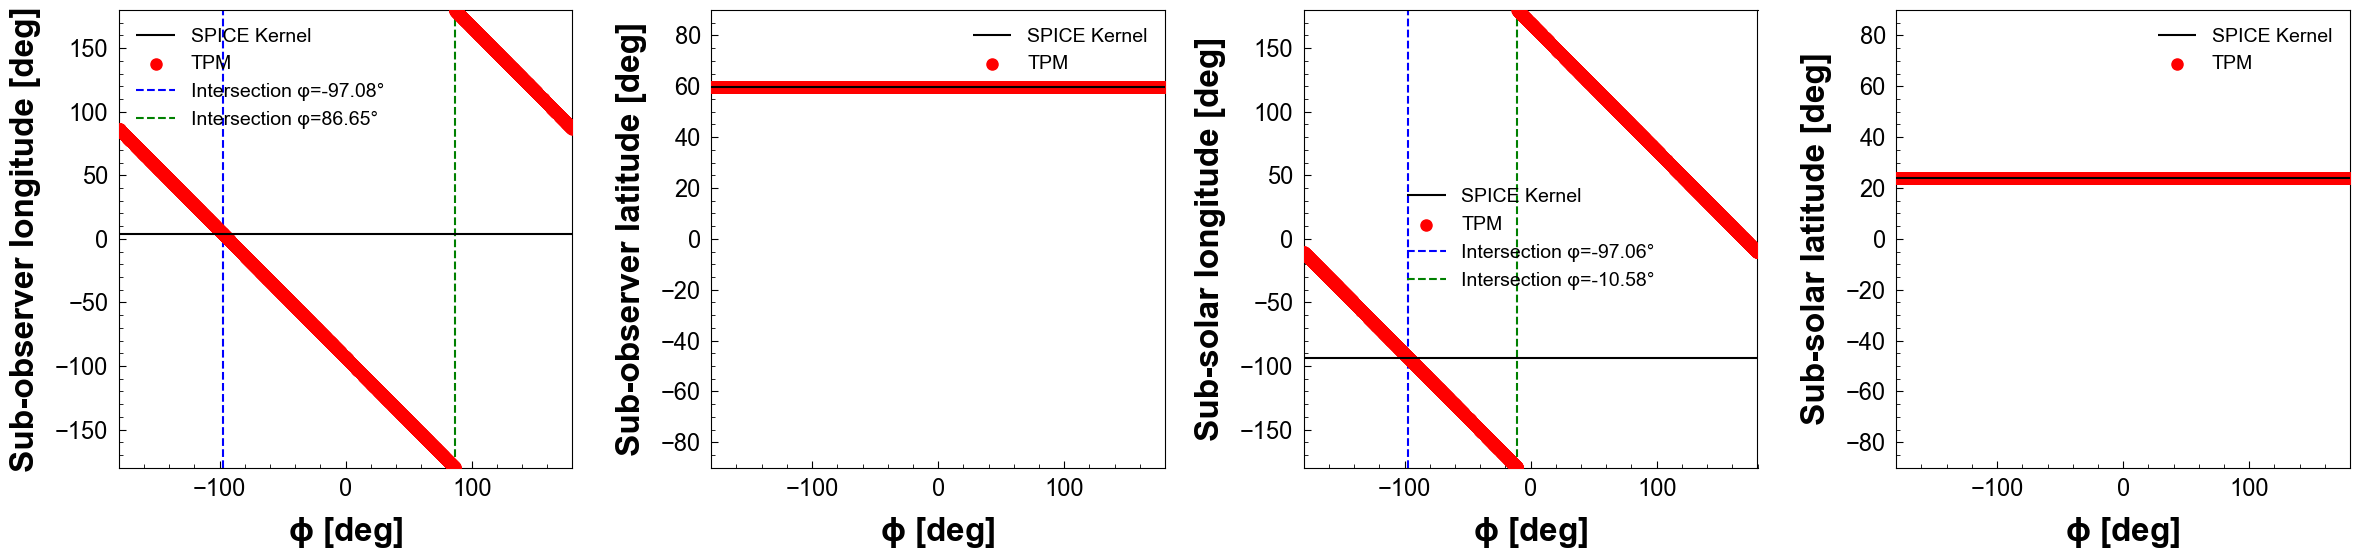

In [165]:
# Plot sub-observer point
plot_subobserver_subsolar(phi0_tpm, solon1, solat1, sslon1, sslat1, solon_epoch1, solat_epoch1, sslon_epoch1, sslat_epoch1)


## Epoch 2: 2009-08-22
- `phi0` ~ -96.94 (to match sub-observer points), -97.35 (to match sub-solar point)

In [166]:
# Make ephemeris and observation file
f_eph = "../test/eph_Phobos_epoch2.txt"
f_obs = "../test/obs_Phobos_epoch2.txt"
utc0 = "2009-08-21T12:06:25.0525"
utc1 = "2009-08-22T12:06:25.0525"

make_eph_obs_Phobos(f_eph, f_obs, utc0, utc1, vec_o_0_epoch2, vec_o_1_epoch2, vec_s_0_epoch2, vec_s_1_epoch2)

Phobos -> Observer
 (X0, Y0, Z0) = (0.0000077113, -0.0000541788, -0.0000537500)
 (X1, Y1, Z1) = (0.0000101782, 0.0000624558, -0.0000058122)
Phobos -> Sun
 (x0, y0, z0) = (-0.9440698343, -1.1302231389, -0.0005123974)
 (x1, y1, z1) = (-0.9337904634, -1.1402927542, -0.0009892335)


In [167]:
# Run TPM for all phi0 and save sub-observer and sub-solar points
solon2, solat2, sslon2, sslat2 = runtpm_Phobos(f_obj, f_eph, f_obs, spinfile_list, eps, TI, BondA, ca, cr)

Command: echo ../test/Phobos_lowres.obj ../test/eph_Phobos_epoch2.txt 0.9 0 0.1 0 0 | runtpm -o ../test/obs_Phobos_epoch2.txt -S ../test/spinfiles/spin_Phobos_phi0_-180.0.txt | grep "so>"
ss> 2455066.0044566263 151.57 -14.59	so> 356.88  -2.74
['ss>', '2455066.0044566263', '151.57', '-14.59\tso>', '356.88', '', '-2.74']
Command: echo ../test/Phobos_lowres.obj ../test/eph_Phobos_epoch2.txt 0.9 0 0.1 0 0 | runtpm -o ../test/obs_Phobos_epoch2.txt -S ../test/spinfiles/spin_Phobos_phi0_-179.9.txt | grep "so>"
ss> 2455066.0044566263 151.47 -14.59	so> 356.78  -2.74
['ss>', '2455066.0044566263', '151.47', '-14.59\tso>', '356.78', '', '-2.74']
Command: echo ../test/Phobos_lowres.obj ../test/eph_Phobos_epoch2.txt 0.9 0 0.1 0 0 | runtpm -o ../test/obs_Phobos_epoch2.txt -S ../test/spinfiles/spin_Phobos_phi0_-179.8.txt | grep "so>"
ss> 2455066.0044566263 151.37 -14.59	so> 356.68  -2.74
['ss>', '2455066.0044566263', '151.37', '-14.59\tso>', '356.68', '', '-2.74']
Command: echo ../test/Phobos_lowres.o

Sub-observer longitude [deg] intersections at: [-96.94473600494759, 176.8760613325735]
Sub-solar longitude [deg] intersections at: [-97.35184529195685, -28.48086917330899]


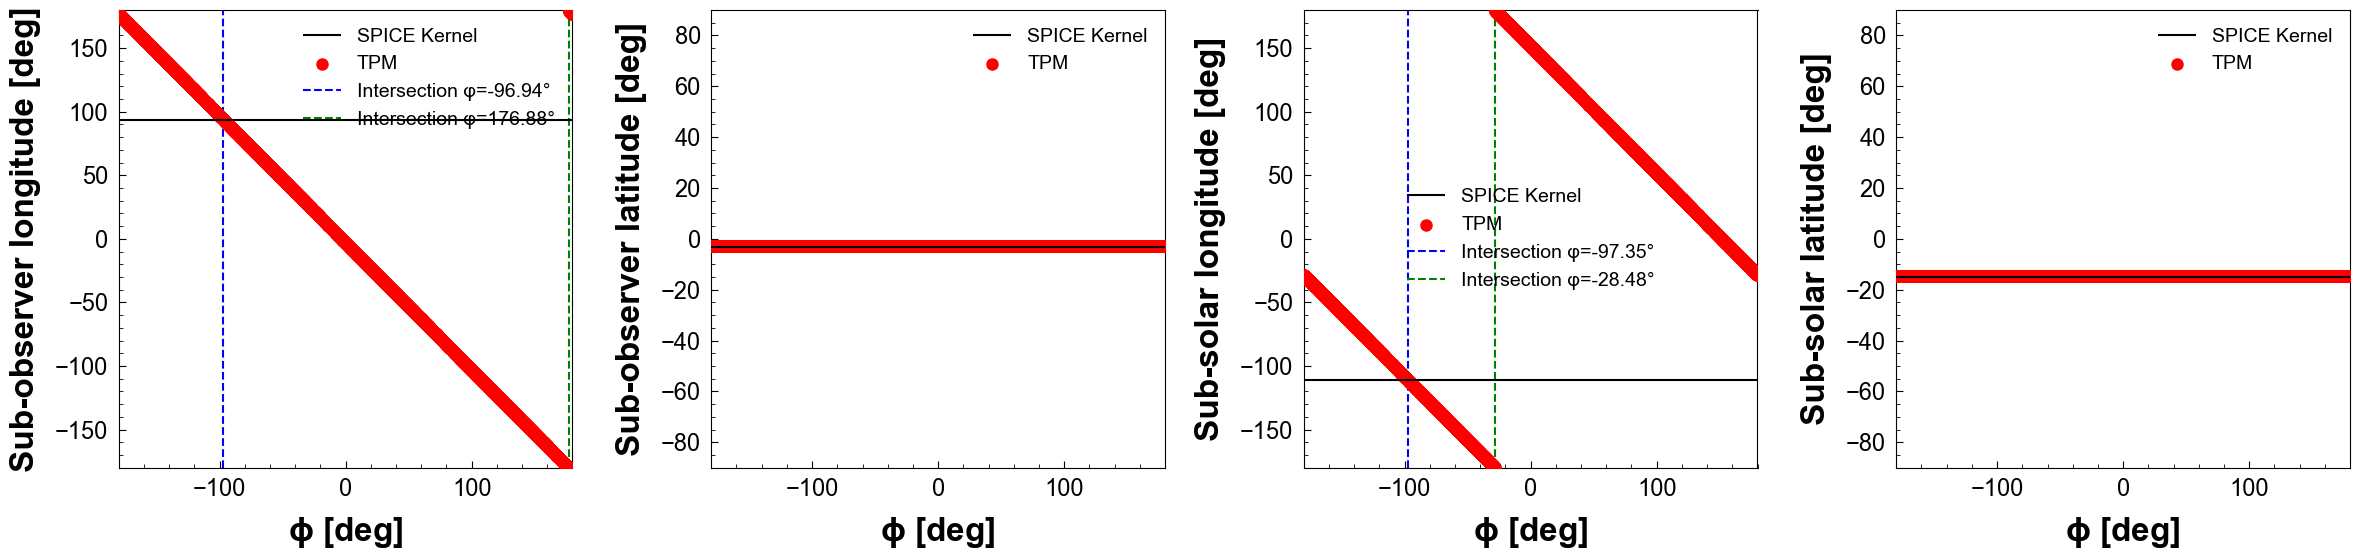

In [168]:
# Plot sub-observer point
plot_subobserver_subsolar(phi0_tpm, solon2, solat2, sslon2, sslat2, solon_epoch2, solat_epoch2, sslon_epoch2, sslat_epoch2)